<a href="https://colab.research.google.com/github/sda96/Dacon_Shoppingmall_Visaulization/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 쇼핑몰 지점별 매출액 시각화 경진대회


## 1. 문제 정의

해당 경진대회의 목적은 어떠한 변수가 각 쇼핑몰 지점별 매출액에 긍정적인 영향을 끼치는지 데이터를 직접 들여다보며 파악하고자 합니다.

분석에 사용되는 데이터의 변수들은 다음과 같습니다.
- id : 샘플 아이디
- Store : 쇼핑몰 지점
- Date : 주 단위(Weekly) 날짜
- Temperature : 해당 쇼핑몰 주변 기온
- Fuel_Price : 해당 쇼핑몰 주변 연료 가격
- Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보
- Unemployment : 해당 쇼핑몰 지역의 실업률
- IsHoliday : 해당 기간의 공휴일 포함 여부
- Weekly_Sales : 주간 매출액 (목표 예측값)

## 2. 작업 환경 세팅

작업 환경은 Colab에서 진행하였습니다.  
그래서 분석과 시각화에 필요한 기초 설정을 마치고 분석을 진행하겠습니다.

In [ ]:
# Colab 한글 꺠짐 현상 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,184 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷

In [ ]:
import os, sys
from google.colab import drive

# Colab 작업 환경을 Google Drive에 연결
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Toy_Project/Dacon/shopping_visualization')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. 데이터 불러오기 및 살펴보기

설정이 완료되었으니 Dacon 데이터를 직접 살펴볼 차례로 Dacon에서 제공한 데이터는 train.csv와 test.csv가 존재하지만 train.csv에 있는 정보를 위주로 진행하겠습니다.

In [ ]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")
print(f"데이터 개수 : {train.shape[0]}")
print(f"변수 개수 : {train.shape[1]}")
train.head()

데이터 개수 : 6255
변수 개수 : 13


id  Store        Date  Temperature  Fuel_Price  Promotion1  Promotion2  \
0   1      1  05/02/2010        42.31       2.572         NaN         NaN   
1   2      1  12/02/2010        38.51       2.548         NaN         NaN   
2   3      1  19/02/2010        39.93       2.514         NaN         NaN   
3   4      1  26/02/2010        46.63       2.561         NaN         NaN   
4   5      1  05/03/2010        46.50       2.625         NaN         NaN   

   Promotion3  Promotion4  Promotion5  Unemployment  IsHoliday  Weekly_Sales  
0         NaN         NaN         NaN         8.106      False    1643690.90  
1         NaN         NaN         NaN         8.106       True    1641957.44  
2         NaN         NaN         NaN         8.106      False    1611968.17  
3         NaN         NaN         NaN         8.106      False    1409727.59  
4         NaN         NaN         NaN         8.106      False    1554806.68

데이터에서 Date와 Weekly_Sales라는 변수명을 통하여 데이터는 주 단위로 저장되어있습니다.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


데이터의 각 변수의 타입과 결측치를 확인한 내용은 다음과 같습니다.
- Date 변수는 object로 현재 string 타입이기 때문에 `pd.to_datetime()` 으로 날짜형 타입으로 바꾸겠습니다.
- Temperature, Fuel_Price, Unemployment, Weekly_Sales, Promotion은 숫자형 변수입니다.
- Store, IsHoliday는 범주형 변수일지도 모르기에 직접 확인할 필요가 있습니다.
- Promotion의 경우 결측치가 많이 존재하는 것으로 보아 모든 데이터에 존재하는게 아닌 일부 날짜에만 진행된 것으로 보입니다.

In [ ]:
train.describe()

id        Store  Temperature   Fuel_Price    Promotion1  \
count  6255.000000  6255.000000  6255.000000  6255.000000   2102.000000   
mean   3128.000000    23.000000    60.639199     3.344369   7155.930661   
std    1805.807299    12.988211    18.624094     0.455364   8408.206085   
min       1.000000     1.000000    -2.060000     2.472000      0.270000   
25%    1564.500000    12.000000    47.170000     2.917000   1844.295000   
50%    3128.000000    23.000000    62.720000     3.413000   5221.140000   
75%    4691.500000    34.000000    75.220000     3.722000   9199.242500   
max    6255.000000    45.000000   100.140000     4.308000  88646.760000   

          Promotion2     Promotion3    Promotion4     Promotion5  \
count    1592.000000    1885.000000   1819.000000    2115.000000   
mean     3308.125810    1462.535523   3465.952501    4518.993173   
std      9382.823804    9667.580258   6413.116294    6048.661908   
min      -265.760000     -29.100000      0.410000     135.160000   
25%        39.755000       4.700000    499.895000    1742.305000   
50%       205.410000      24.600000   1532.630000    3226.410000   
75%      1931.005000     104.010000   3640.905000    5444.030000   
max    104519.540000  141630.610000  67474.850000  108519.280000   

       Unemployment  Weekly_Sales  
count   6255.000000  6.255000e+03  
mean       8.029236  1.047619e+06  
std        1.874875  5.654362e+05  
min        4.077000  2.099862e+05  
25%        6.916500  5.538695e+05  
50%        7.906000  9.604761e+05  
75%        8.622000  1.421209e+06  
max       14.313000  3.818686e+06

각 변수들을 5점 요약 수치표를 출력한 내용을 통하여 다음과 같은 내용을 파악하였습니다.
- id는 말그대로 각 데이터가 가지는 식별 번호이기 때문에 분석에 큰 영향을 끼치지 않을 것으로 보입니다.
- Promotion의 경우 최솟값으로 - 도 포함하고 있으며 해당 정보가 가지는 의미는 좀 더 분석이 필요하겠습니다.
- Temperature의 경우 평균값이 일반적으로 생각하는 섭씨온도에서는 나올 수 없는 수치이기 화씨온도를 기준으로 하였다고 생각되며 섭씨변환이 필요합니다.
- 쇼핑몰 지점인 Store는 1 ~ 45까지 존재하기에 45개의 지점에 대한 정보를 가지 데이터셋이라는 것을 알 수 있었습니다.

## 4. 데이터 전처리

앞서 데이터 살펴보기에서 얻은 정보를 바탕으로 수행해야 하는 데이터 전처리는 다음과 같습니다.
1. Date 변수 datetime 타입으로 변환하기
2. Temperatrue 변수 섭씨변환하기

이외에도 변수간의 객관적인 비교를 위하여 범위를 통일하고자 scaling을 진행하겠습니다.
3. Temperature, Fuel_Price, Unemployment, Weekly_Sales 변수들 min-max scaling

In [ ]:
# 화씨를 섭씨로 변환하는 함수
def F2C(Fahrenheit):
  Celsius = (Fahrenheit - 32) * 5 / 9
  return Celsius

# min-max scaler 함수
def minmaxscaler(x):
  return (x - x.min()) / (x.max() - x.min())

In [ ]:
data = train.copy()

# 1. Date 변수 dateime 타입으로 변환하기
data["Date"] = pd.to_datetime(data["Date"])
data = data.set_index("id")
data = data.sort_values("Date")

# 2. Temperature 변수 섭씨변환하기
data["Temperature"] = data["Temperature"].apply(F2C)

# 3. Temperature, Fuel_Price, Unemployment, Weekly_Sales scaling
data["Temperature"] = minmaxscaler(data["Temperature"])
data["Fuel_Price"] = minmaxscaler(data["Fuel_Price"])
data["Unemployment"] = minmaxscaler(data["Unemployment"])
data["Weekly_Sales"] = minmaxscaler(data["Weekly_Sales"])
data.describe()

Store  Temperature   Fuel_Price    Promotion1     Promotion2  \
count  6255.000000  6255.000000  6255.000000   2102.000000    1592.000000   
mean     23.000000     0.613495     0.475147   7155.930661    3308.125810   
std      12.988211     0.182232     0.248020   8408.206085    9382.823804   
min       1.000000     0.000000     0.000000      0.270000    -265.760000   
25%      12.000000     0.481703     0.242375   1844.295000      39.755000   
50%      23.000000     0.633855     0.512527   5221.140000     205.410000   
75%      34.000000     0.756164     0.680828   9199.242500    1931.005000   
max      45.000000     1.000000     1.000000  88646.760000  104519.540000   

          Promotion3    Promotion4     Promotion5  Unemployment  Weekly_Sales  
count    1885.000000   1819.000000    2115.000000   6255.000000   6255.000000  
mean     1462.535523   3465.952501    4518.993173      0.386111      0.232115  
std      9667.580258   6413.116294    6048.661908      0.183165      0.156687  
min       -29.100000      0.410000     135.160000      0.000000      0.000000  
25%         4.700000    499.895000    1742.305000      0.277403      0.095293  
50%        24.600000   1532.630000    3226.410000      0.374072      0.207967  
75%       104.010000   3640.905000    5444.030000      0.444021      0.335640  
max    141630.610000  67474.850000  108519.280000      1.000000      1.000000

Temperature, Fuel_Price, Unemployment, Weekly_Sales에 scaling이 잘 되었는지  `data.describe()`로 확인하였더니 최소값이 0이고 최대값이 1로 나오기에 잘 적용되었다고 볼 수 있습니다.

## 5. 데이터 EDA 및 시각화

데이터 EDA는 서로 다른 특징을 가지는 숫자형 변수와 범주형 변수를 나누어서 진행하고 마지막으로는 Promotion 변수가 어떠한 의미를 가지는 변수인지 분석하겠습니다.


### 5.1 범주형 변수 EDA 및 시각화

범주형 변수인 Store, IsHoliday가 Weekley_Sales에 미치는 영향을 알아보겠습니다.  
우선적으로 각 변수마다 몇개의 범주, 레이블이 존재하는지 확인해보겠습니다.

In [ ]:
category = data[["Date", "Store", "IsHoliday", "Weekly_Sales"]]
group_store = category.groupby("Store")
group_isholiday = category.groupby("IsHoliday")

print(f"Store 변수 레이블 개수 : {len(group_store)}")
print(f"IsHoliday 변수 레이블 개수 : {len(group_isholiday)}")

Store 변수 레이블 개수 : 45
IsHoliday 변수 레이블 개수 : 2


확인 결과 Store의 레이블의 개수는 45개의 지점을 가지는 것을 알 수 가 있었고 IsHoliday 변수는 공휴일 여부만 가지기 때문에 2개를 가지는 것을 알 수 가 있었습니다.

#### 5.1.1 지점별 시간에 따른 매출 추이 시각화

분석 목적에 맞는 지점별 매출 추이를 시간에 따라서 꺾은선 그래프로 표현하여 정보를 얻어보도록 하겠습니다.

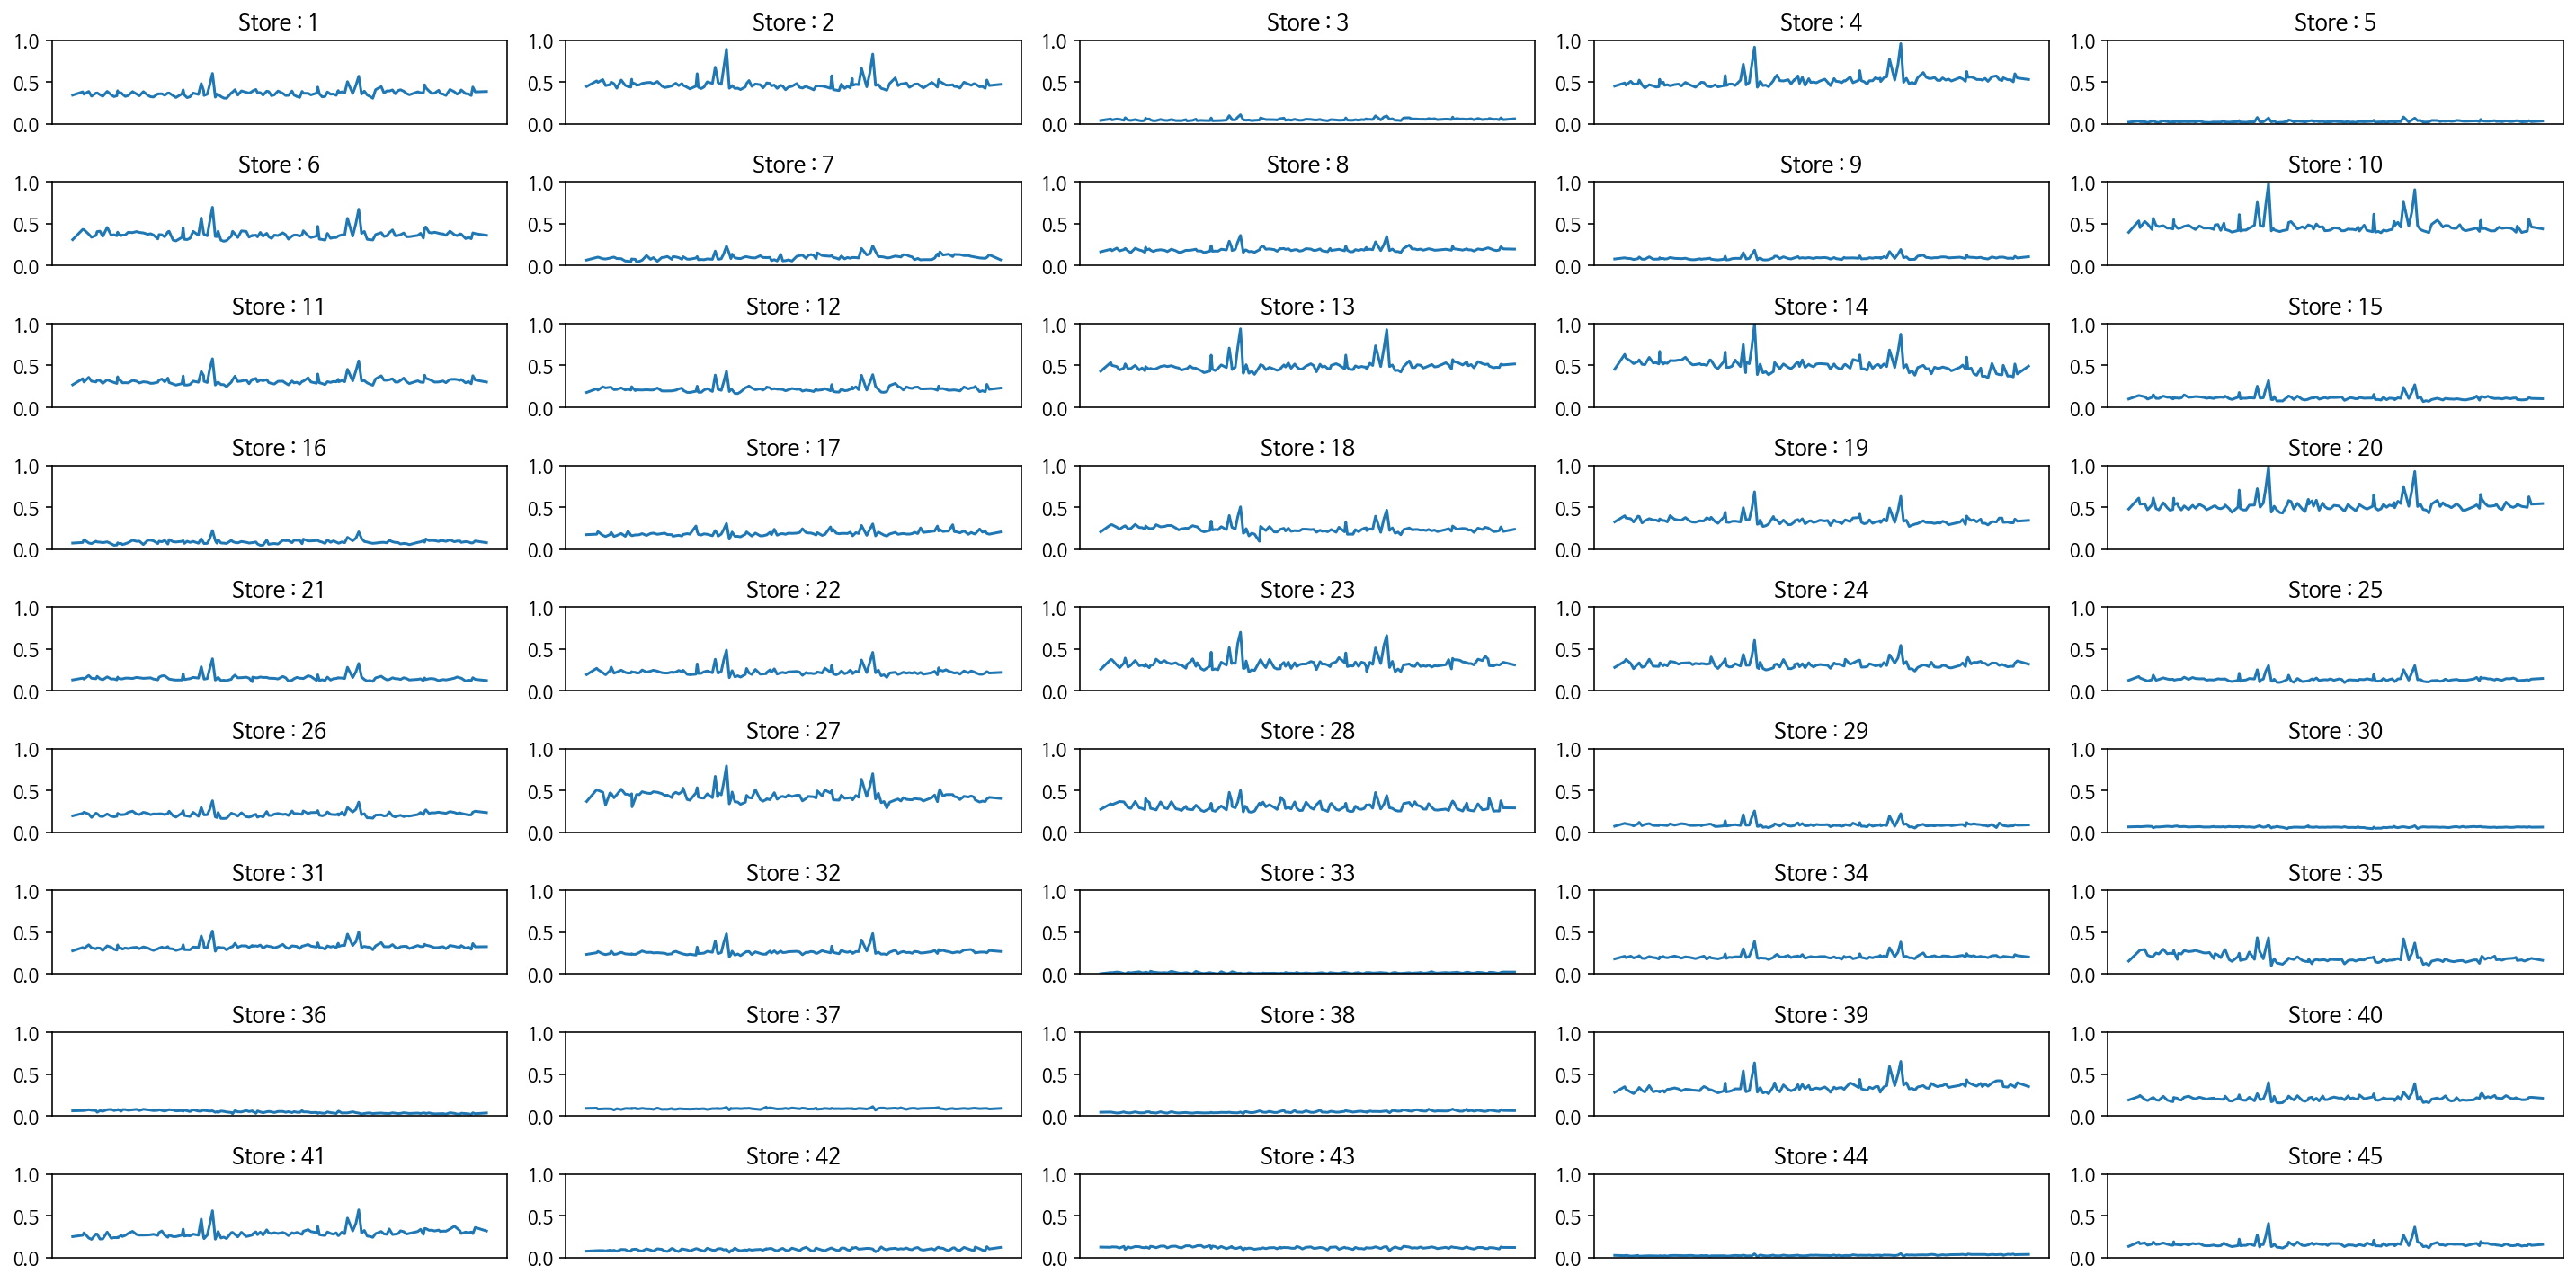

In [ ]:
fig, axes = plt.subplots(9, 5, figsize = (20, 10))
axes = axes.ravel()

for idx, element in enumerate(zip(axes, group_store)):
  axis, group = element
  store, df = group
  df_x = df["Date"]
  df_y = df["Weekly_Sales"]
  axis.plot(df_x, df_y)
  axis.set_ylim([0, 1])
  axis.get_xaxis().set_visible(False)
  axis.set_title(f"Store : {store}")

plt.tight_layout()
plt.show()

각 지점별 매출 추이로 시각화 한 결과 아래와 같은 내용을 얻을 수 있었습니다.
- 전체적으로 지점별 매출 추이는 2가지 형태를 가집니다.
  - 첫 번째는 시간에 따라 매출에 어떠한 변동을 보이지 않는 형태
  - 두 번째는 시간에 따라 매출의 변화가 크며 특정 구간에서 매출이 크게 뛰는 구간이 2개의 구간을 가진 형태

두 번째 형태에서 보이는 특정 구간에서 매출의 변화량이 큰 구간에 대해서 집중적으로 분석하는 것이 매출에 영향을 준 변수가 무엇인지 찾을 수 있는 방향성을 제시해준다고 생각합니다.

#### 5.1.2 매출 변화량이 큰 2개의 구간 찾아내기

매출 변화량이 급격히 변하는 구간을 찾기 위해서 해당 형태를 띄는 지점중 예시로 하나를 선택하고 해당 지점의 이상치를 가지는 구간이 매출이 급격히 변하는 구간이다 라는 가설을 세우고 분석을 진행하겠습니다.

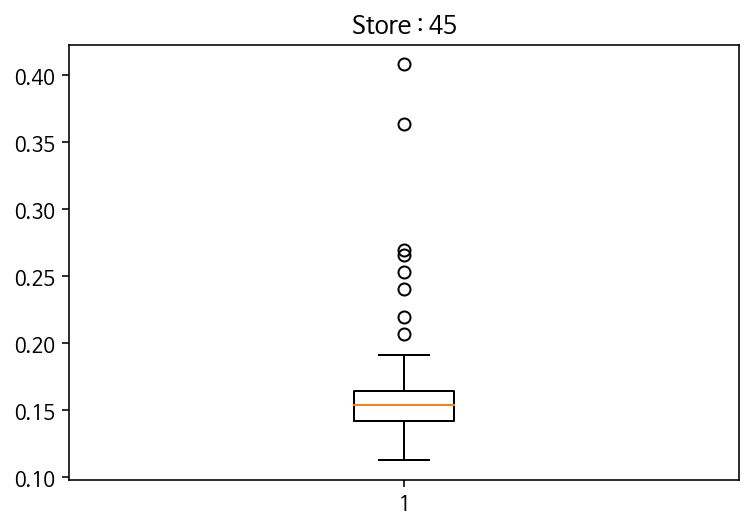

In [ ]:
# Store 45의 박스플랏
plt.boxplot(df["Weekly_Sales"])
plt.title("Store : 45")
plt.show()

박스플랏에서 사분위수 범위를 넘어가는 값들은 이상치로 간주되기 때문에 사분위수 범위 밖에 있는 값들만 추출하겠습니다.

In [ ]:
df_desc = df.describe()
Q1 = df_desc.loc["25%", "Weekly_Sales"]
Q3 = df_desc.loc["75%", "Weekly_Sales"]
IQR = Q3 - Q1
upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

# and = & , or = |
outlier = df[(df["Weekly_Sales"] > upper_bound) | (df["Weekly_Sales"] < lower_bound)]
outlier_date = pd.to_datetime(outlier["Date"])
print(outlier)

           Date  Store  IsHoliday  Weekly_Sales
id                                             
6161 2010-10-12     45      False      0.219574
6159 2010-11-26     45       True      0.269491
6162 2010-12-17     45      False      0.253082
6163 2010-12-24     45      False      0.408146
6213 2011-09-12     45      False      0.207047
6211 2011-11-25     45       True      0.266214
6214 2011-12-16     45      False      0.240785
6215 2011-12-23     45      False      0.363558


지점별 매출 추이 그림 위에 이상치로 뽑은 날짜들을 표시를 해보겠습니다.

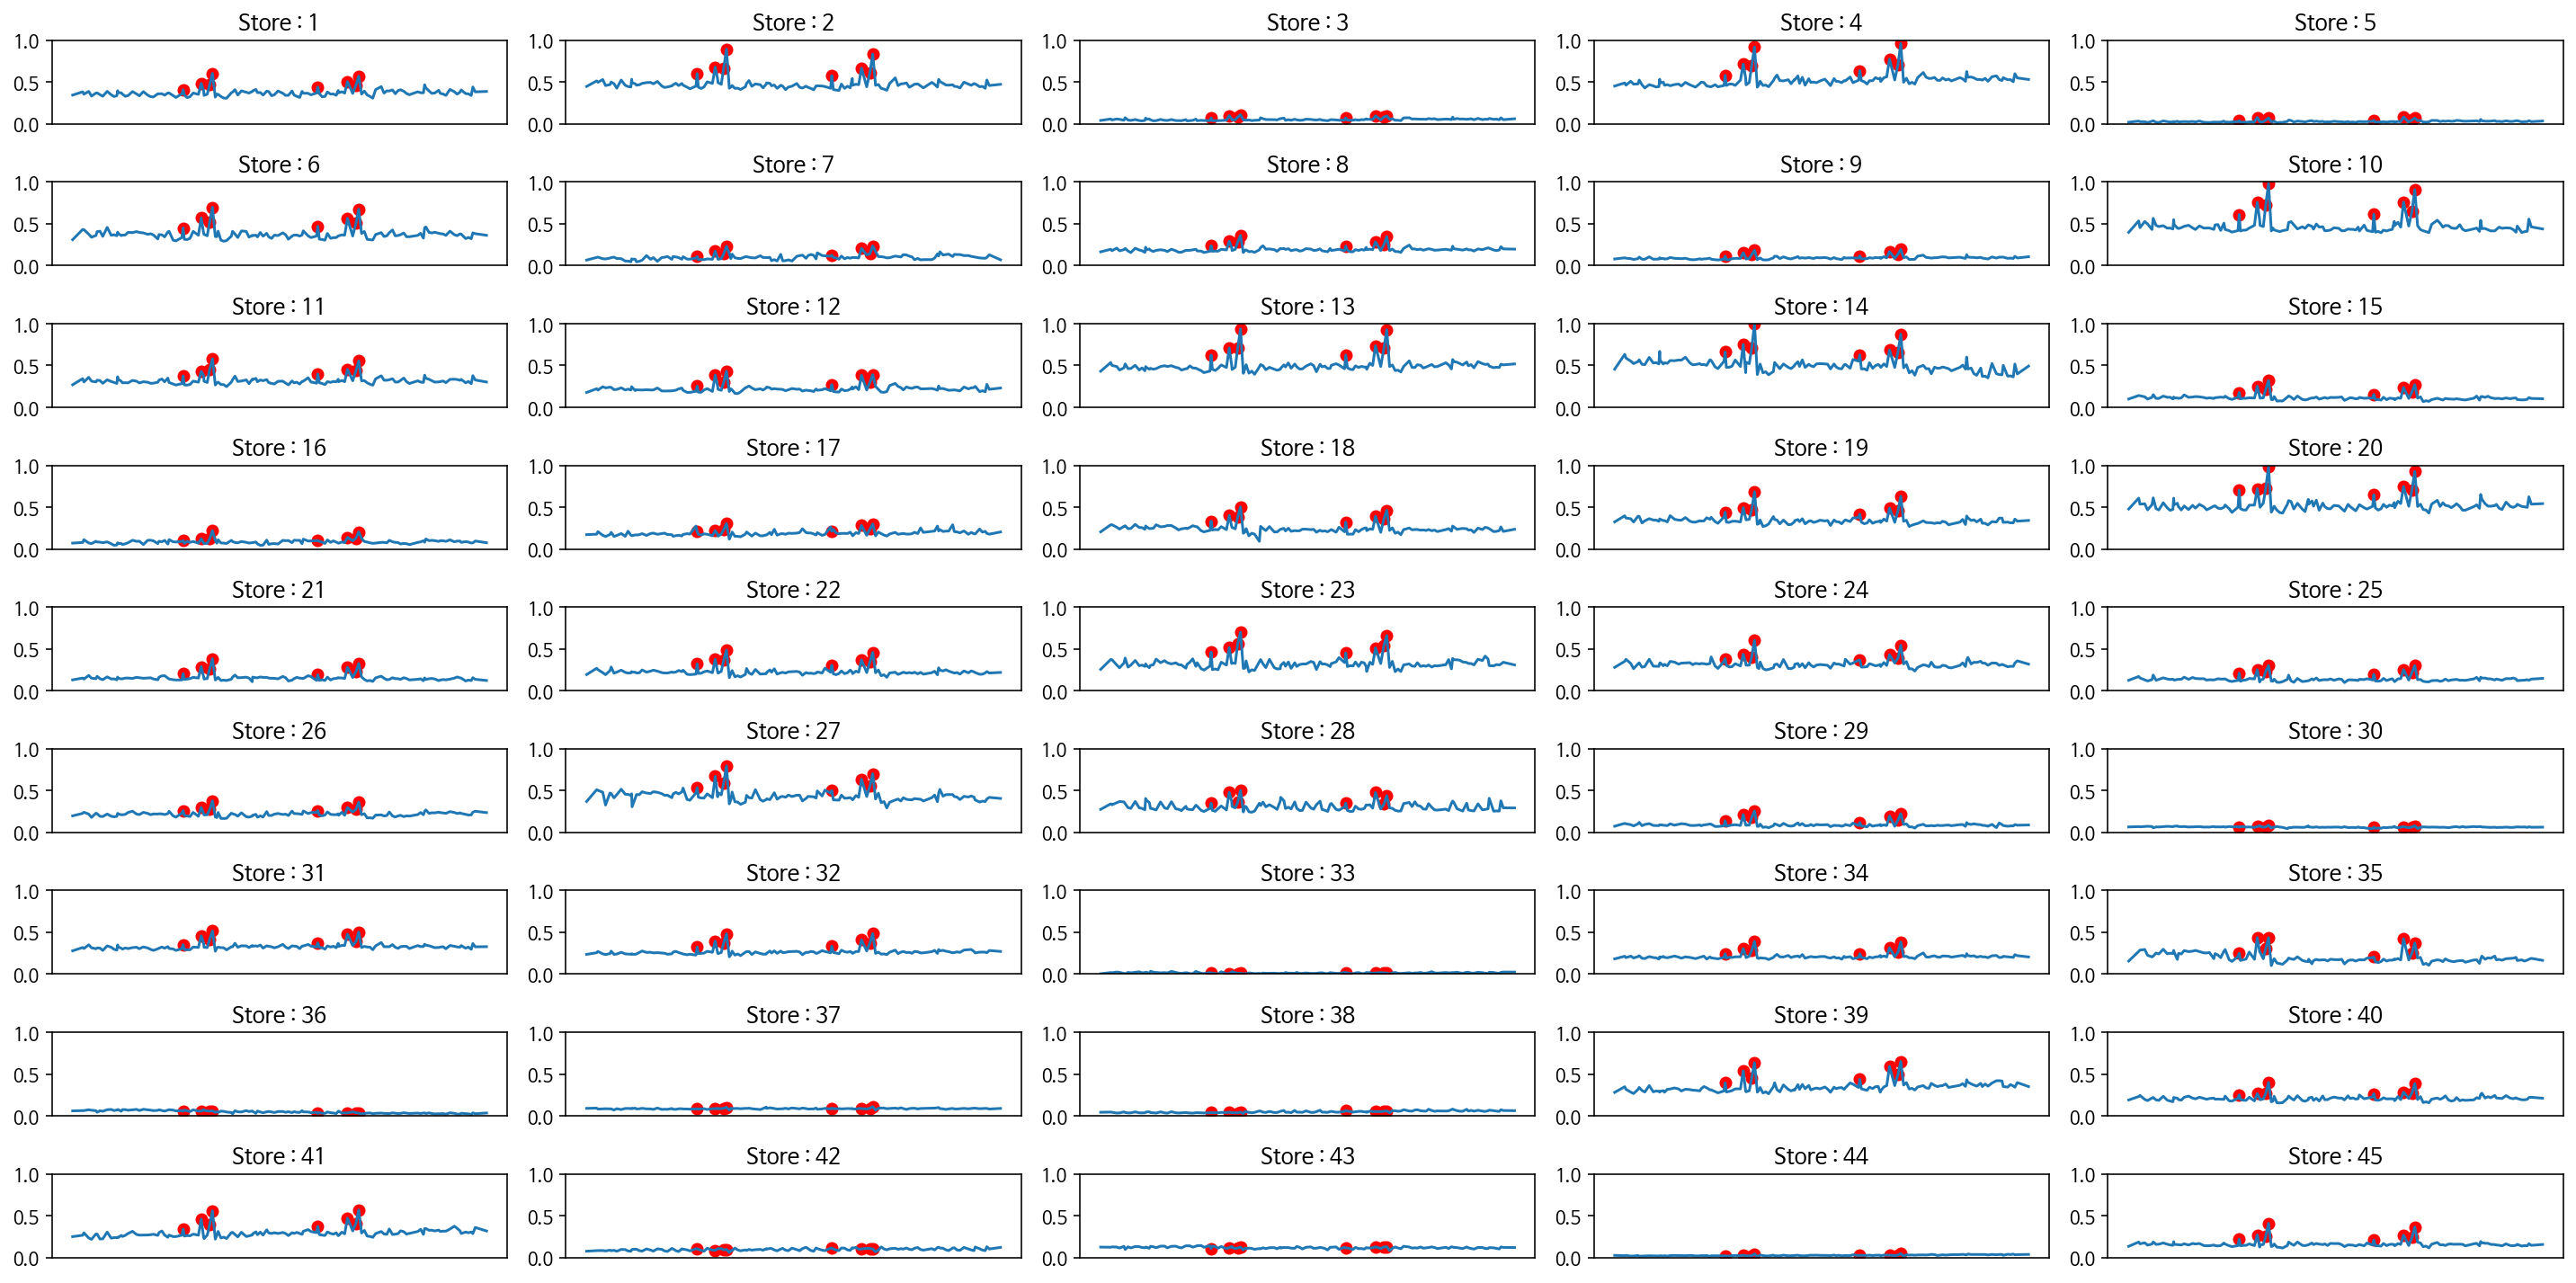

In [ ]:
fig, axes = plt.subplots(9, 5, figsize = (20, 10))
axes = axes.ravel()

for idx, element in enumerate(zip(axes, group_store)):
  axis, group = element
  store, df = group
  df_x = df["Date"]
  df_y = df["Weekly_Sales"]
  outlier_x = outlier_date
  outlier_y = [df[df["Date"] == i]["Weekly_Sales"].values[0] for i in outlier_date]

  axis.plot(df_x, df_y)
  axis.scatter(outlier_x, outlier_y, color = "red")

  axis.set_ylim([0, 1])
  axis.get_xaxis().set_visible(False)
  axis.set_title(f"Store : {store}")

plt.tight_layout()
plt.show()

위의 그림과 같이 시각화한 결과 앞서 예시로 사용한 Store 45 에서 찾은 이상치의 날짜와 다른 Store에서 매출 변화량이 큰 날짜와 동일하다는 것을 알 수 있었습니다.

**시각화 분석 내용 정리**
- 지점별 시간에 따른 매출 추이를 꺾은선 그래프로 시각화하였습니다.
- 매출 추이 시각화를 통하여 지점별로 동일한 시점에서 매출의 변화량이 크게 발생한다는 것을 발견하였습니다.
- 매출 변화량이 큰 부분을 찾기 위해서 해당 부분을 이상치라는 가설을 세우고 접근하였습니다
- 그 결과 이상치 지점은 매출 변화량이 큰 지점과 동일하였고 다른 지점들 또한 매출 변화량이 크게 변하는 지점과 동일하였습니다.

**다음 분석 방향성**
- 앞서 이상치 지점이 매출 변화량이 크게 변하는 지점과 동일하다는 지점을 얻었습니다.
- 이를 바탕으로 해당 지점의 기온, 실업률, 유가 정보등 다른 정보와 결합하여 해당 지점이 왜 매출 변화량이 크게 나타났는지 알아보겠습니다.

### 5.2 숫자형 변수 EDA 및 시각화

### 5.2.1 숫자형 변수들의 시간에 따른 추이 시각화

앞선 범주형 변수 EDA 챕터에서 얻은 정보인 이상치 지점의 날짜들을 뽑아서 매출 변화량이 크게 변한 이유를 찾아보겠습니다.

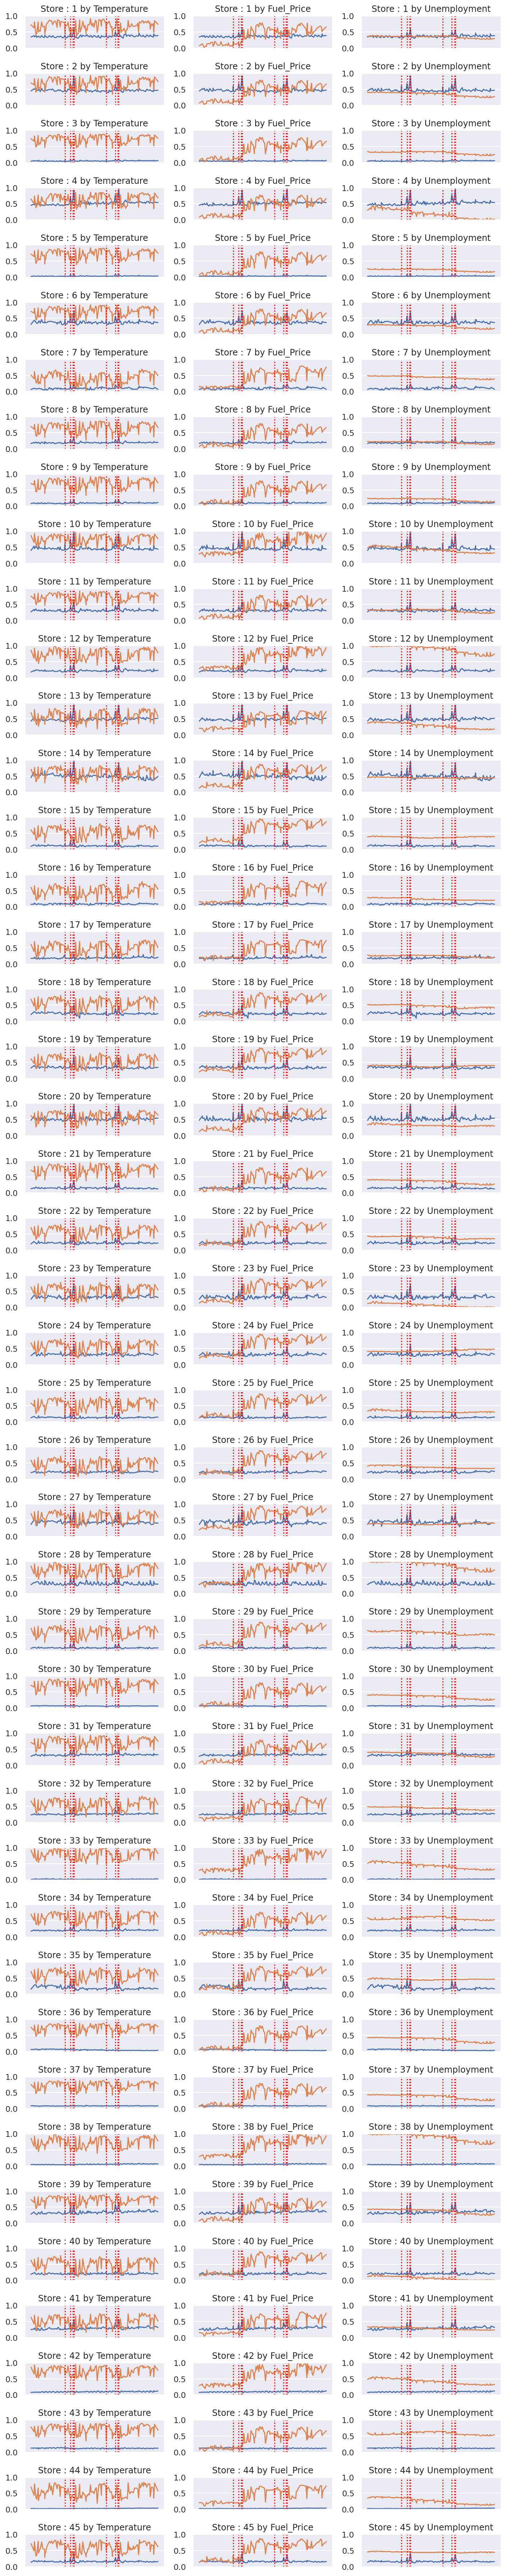

In [ ]:
fig, axes = plt.subplots(45, 3, figsize = (10, 50))
group = data.groupby("Store")

for idx, element in enumerate(zip(axes, group)):
  axis, group = element
  store, df = group

  outlier_x = outlier_date
  outlier_y = [df[df["Date"] == i]["Weekly_Sales"].values[0] for i in outlier_date]

  axis[0].plot(df["Date"], df["Weekly_Sales"], label = "Sales")
  axis[0].plot(df["Date"], df["Temperature"], label = "Temp")
  axis[1].plot(df["Date"], df["Weekly_Sales"], label = "Sales")
  axis[1].plot(df["Date"], df["Fuel_Price"], label = "Fuel")
  axis[2].plot(df["Date"], df["Weekly_Sales"], label = "Sales")
  axis[2].plot(df["Date"], df["Unemployment"], label = "Unem")
  for line in outlier_x:
    axis[0].axvline(line, color = "red", linestyle = ":")
    axis[1].axvline(line, color = "red", linestyle = ":")
    axis[2].axvline(line, color = "red", linestyle = ":")

  axis[0].set_ylim([0, 1])
  axis[1].set_ylim([0, 1])
  axis[2].set_ylim([0, 1])
  axis[0].get_xaxis().set_visible(False)
  axis[1].get_xaxis().set_visible(False)
  axis[2].get_xaxis().set_visible(False)

  axis[0].set_title(f"Store : {store} by Temperature")
  axis[1].set_title(f"Store : {store} by Fuel_Price")
  axis[2].set_title(f"Store : {store} by Unemployment")

plt.tight_layout()
plt.show()

주황색은 비교를 위한 각 변수이고 파랑색은 매출액을 의미할 때, 분석 결과 다음과 같습니다
- Temperature가 낮아지면 일시적으로 매출이 늘어납니다.
- Fuel_Price가 상승하기 시작할 때, 일시적으로 매출이 늘어납니다.
- Unemployment는 관계성이 낮아보입니다.

### 5.2.2 Promotion 변수 시간에 따른 추이 시각화

앞선 시각화에서 매출과 연관성을 지닌 변수가 무엇인지 바로 파악하기가 어려웠습니다.

해당 파트에서는 Promotion 변수들과 Weekly_Sales 변수와 시간에 따른 관련성이 보이는지 확인해보겠습니다.

매출의 범위를 min-max scaling을 하였기에 범위를 통일해주기 위해서 Promotion 변수에도 min-max scaling을 적용합니다.

In [ ]:
data["Promotion1"] = minmaxscaler(data["Promotion1"])
data["Promotion2"] = minmaxscaler(data["Promotion2"])
data["Promotion3"] = minmaxscaler(data["Promotion3"])
data["Promotion4"] = minmaxscaler(data["Promotion4"])
data["Promotion5"] = minmaxscaler(data["Promotion5"])

각 지점별로 앞서 이상치로 찾은 날짜와 Promotion 값의 추이를 시각화하겠습니다.

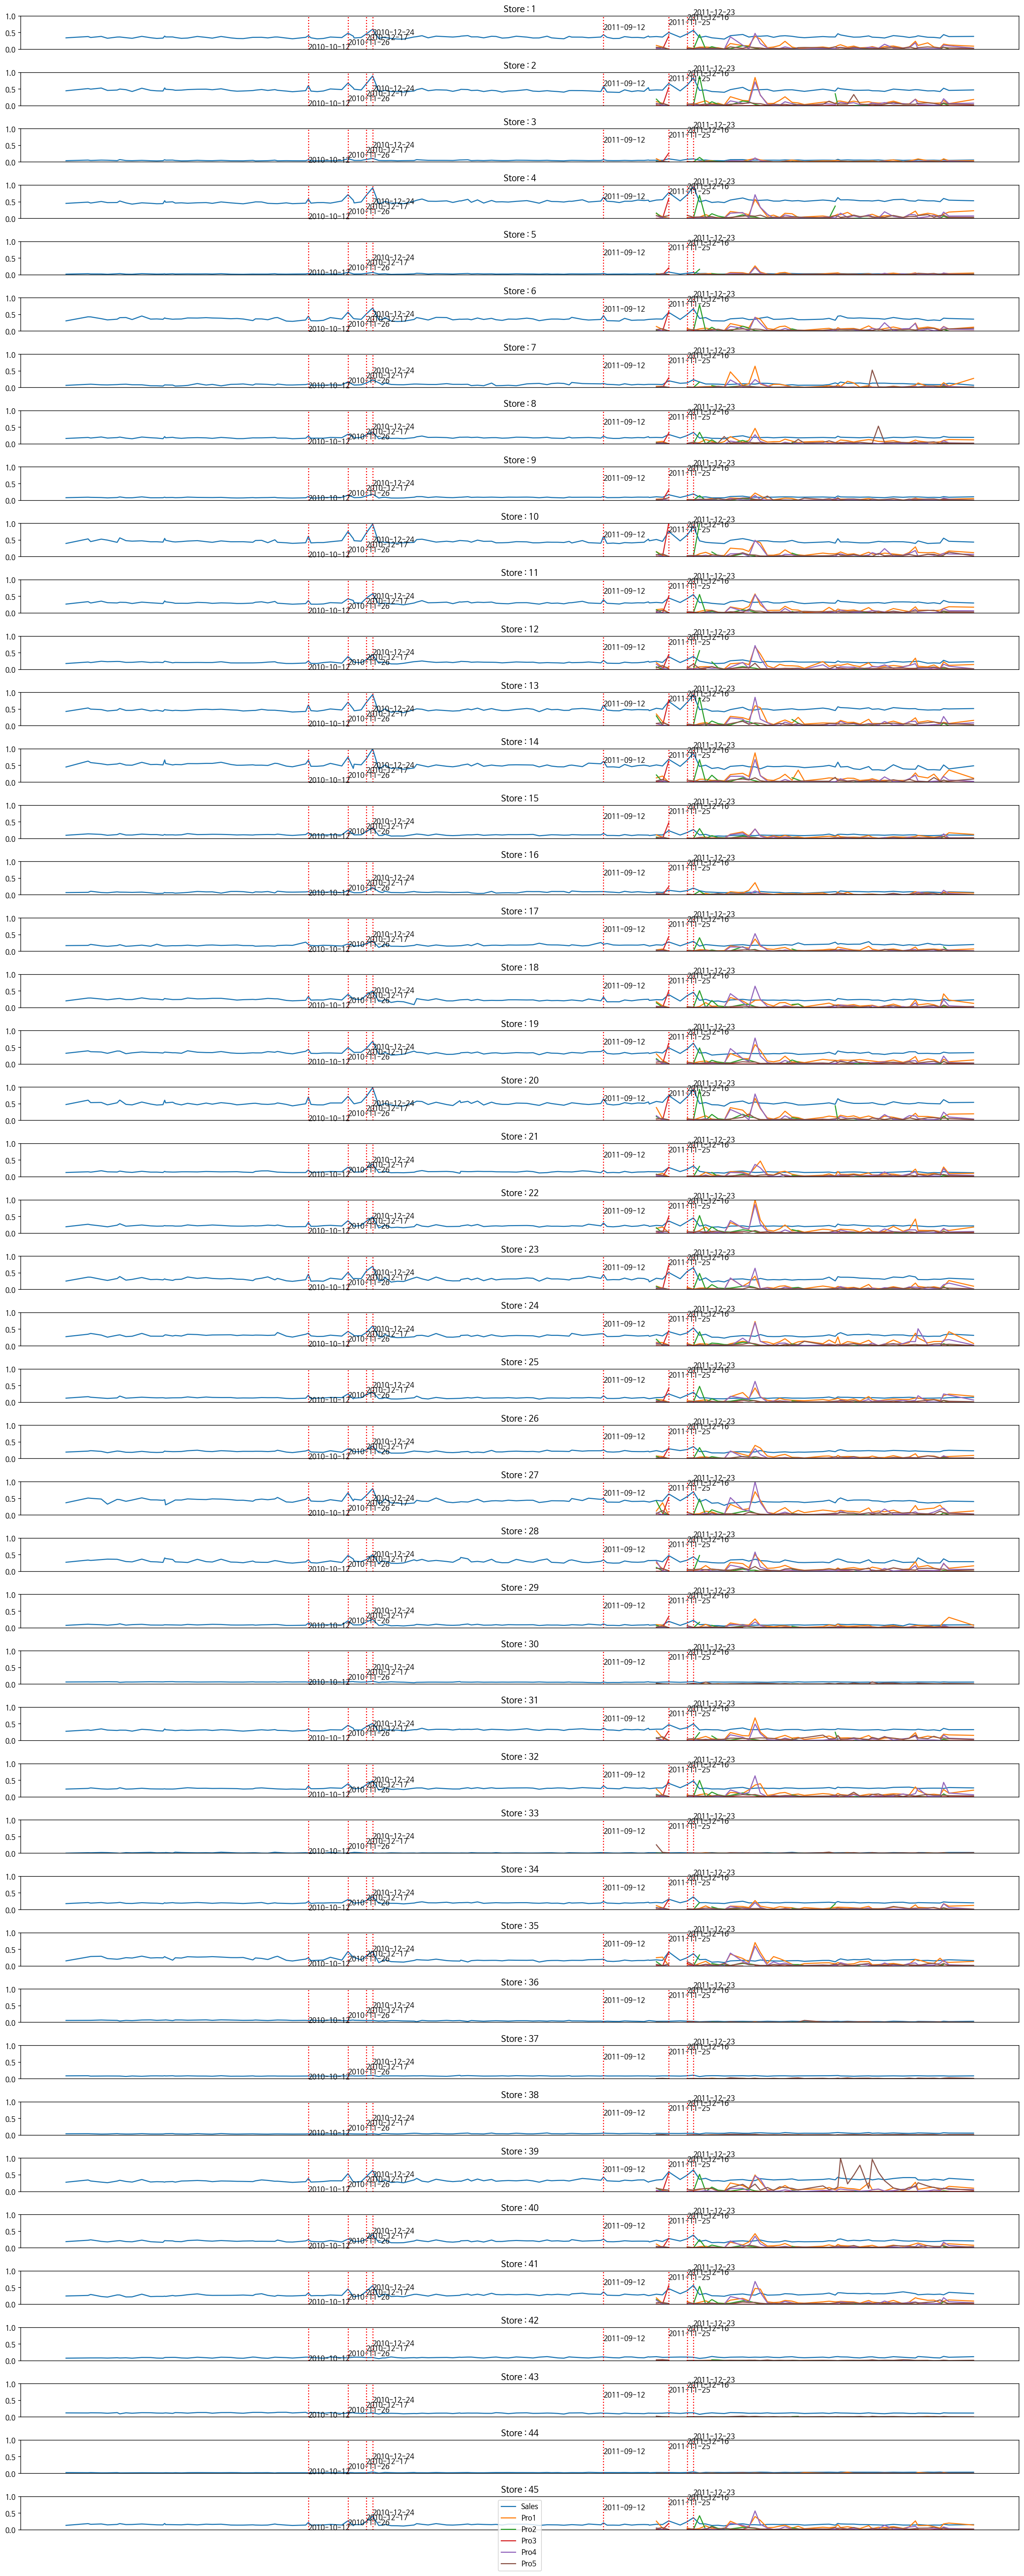

In [ ]:
fig, axes = plt.subplots(45, 1, figsize = (20, 50))
#axes = axes.ravel()
group = data.groupby("Store")

for idx, element in enumerate(zip(axes, group)):
  axis, group = element
  store, df = group

  outlier_x = outlier_date
  outlier_y = [df[df["Date"] == i]["Weekly_Sales"].values[0] for i in outlier_date]

  axis.plot(df["Date"], df["Weekly_Sales"], label = "Sales")
  axis.plot(df["Date"], df["Promotion1"], label = "Pro1")
  axis.plot(df["Date"], df["Promotion2"], label = "Pro2")
  axis.plot(df["Date"], df["Promotion3"], label = "Pro3")
  axis.plot(df["Date"], df["Promotion4"], label = "Pro4")
  axis.plot(df["Date"], df["Promotion5"], label = "Pro5")
  for idx, line in enumerate(outlier_x):
    axis.axvline(line, color = "red", linestyle = ":")
    axis.text(line, (0.15 * idx), line.strftime("%Y-%m-%d"), fontsize = 10)

  axis.set_ylim([0, 1])
  axis.get_xaxis().set_visible(False)
  axis.set_title(f"Store : {store}")


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1))
plt.tight_layout()
plt.show()

Promotion 변수별로 매출액의 추이와 함께 비교한 결과 얻은 내용은 다음과 같습니다.
- 2011년 11월 25일에 Promotion3은 일시적으로 매출액에 큰 영향을 준 변수라고 볼 수 있습니다.
- Promotion3에 의해서 매출액의 변화를 겪은 지점들은 지속적으로 다른 Promotion들도 진행을 한 것으로 보입니다.
- Promotion3에 의해서 매출액의 변화를 겪지 못한 지점들은 새로운 Promotion을 진행하지 않은 것으로 보입니다.

## 6. 시계열 데이터 분석

앞선 데이터 EDA와 시각화를 통하여 다양한 인사이트와 정보들을 얻을 수 있었습니다.

하지만 해당 정보들은 주관적인 판단이 들어간 정성적 평가이기 때문에 객관성이 떨어질 수 있습니다.

그러므로, 객관적인 평가를 위하여 간단한 시계열 분석을 진행하겠습니다.

### 6.1 숫자형 변수들 stationary(정상성) 체크

stationary(정상성)이라는 것은 해당 데이터의 평균과 분산이 시간과 관계없이 일정한 상태를 말합니다.

숫자형 변수들인 Temperature, Fuel_Price, Unemployment, Weekly_Saels들이 정상성을 만족해야 신뢰성 있는 시계열 분석이 가능합니다.

stationary를 체크하기 위해서 Augmented Dickey-Fuller test(ADF test) 가설검정을 진행하며 해당 가설의 귀무가설 H0은 '정상성을 만족하지 못한다' 입니다.

숫자형 변수들에게 ADF test를 수행하여 정상성을 체크하겠습니다.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
  result = adfuller(series)
  print(f"ADF Statistics : {result[0]}")
  print(f"p-value : {result[1]}\n")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print("Weekly_Sales 정상성 체크")
adf_test(data["Weekly_Sales"])

print("Temperature 정상성 체크")
adf_test(data["Temperature"])

print("Fuel_Price 정상성 체크")
adf_test(data["Fuel_Price"])

print("Unemployment 정상성 체크")
adf_test(data["Unemployment"])

Weekly_Sales 정상성 체크
ADF Statistics : -14.727870139130342
p-value : 2.688341601965925e-27

Temperature 정상성 체크
ADF Statistics : -7.165253497911765
p-value : 2.8976446248275185e-10

Fuel_Price 정상성 체크
ADF Statistics : -3.0406540742800137
p-value : 0.03126831839154679

Unemployment 정상성 체크
ADF Statistics : -7.633082713574646
p-value : 1.9849636305065562e-11



모든 숫자형 변수들이 유의수준 0.05보다 작기 때문에 귀무가설인 "정상성을 만족하지 못한다."를 기각하고 대립가설일 "정상성을 만족한다."를 채택하게 되어서 앞으로 시계열 분석에 발생할 오류를 예방할 수 있게 됩니다.

### 6.2 숫자형 변수들간의 상관관계 분석

두 변수의 상관관계를 분석할 때는 일반적인 상관분석을 진행하지만 시간적 특성이 포함된 데이터의 경우 교차 상관분석을 진행해야 올바른 관계의 결과를 얻을 수 있습니다.

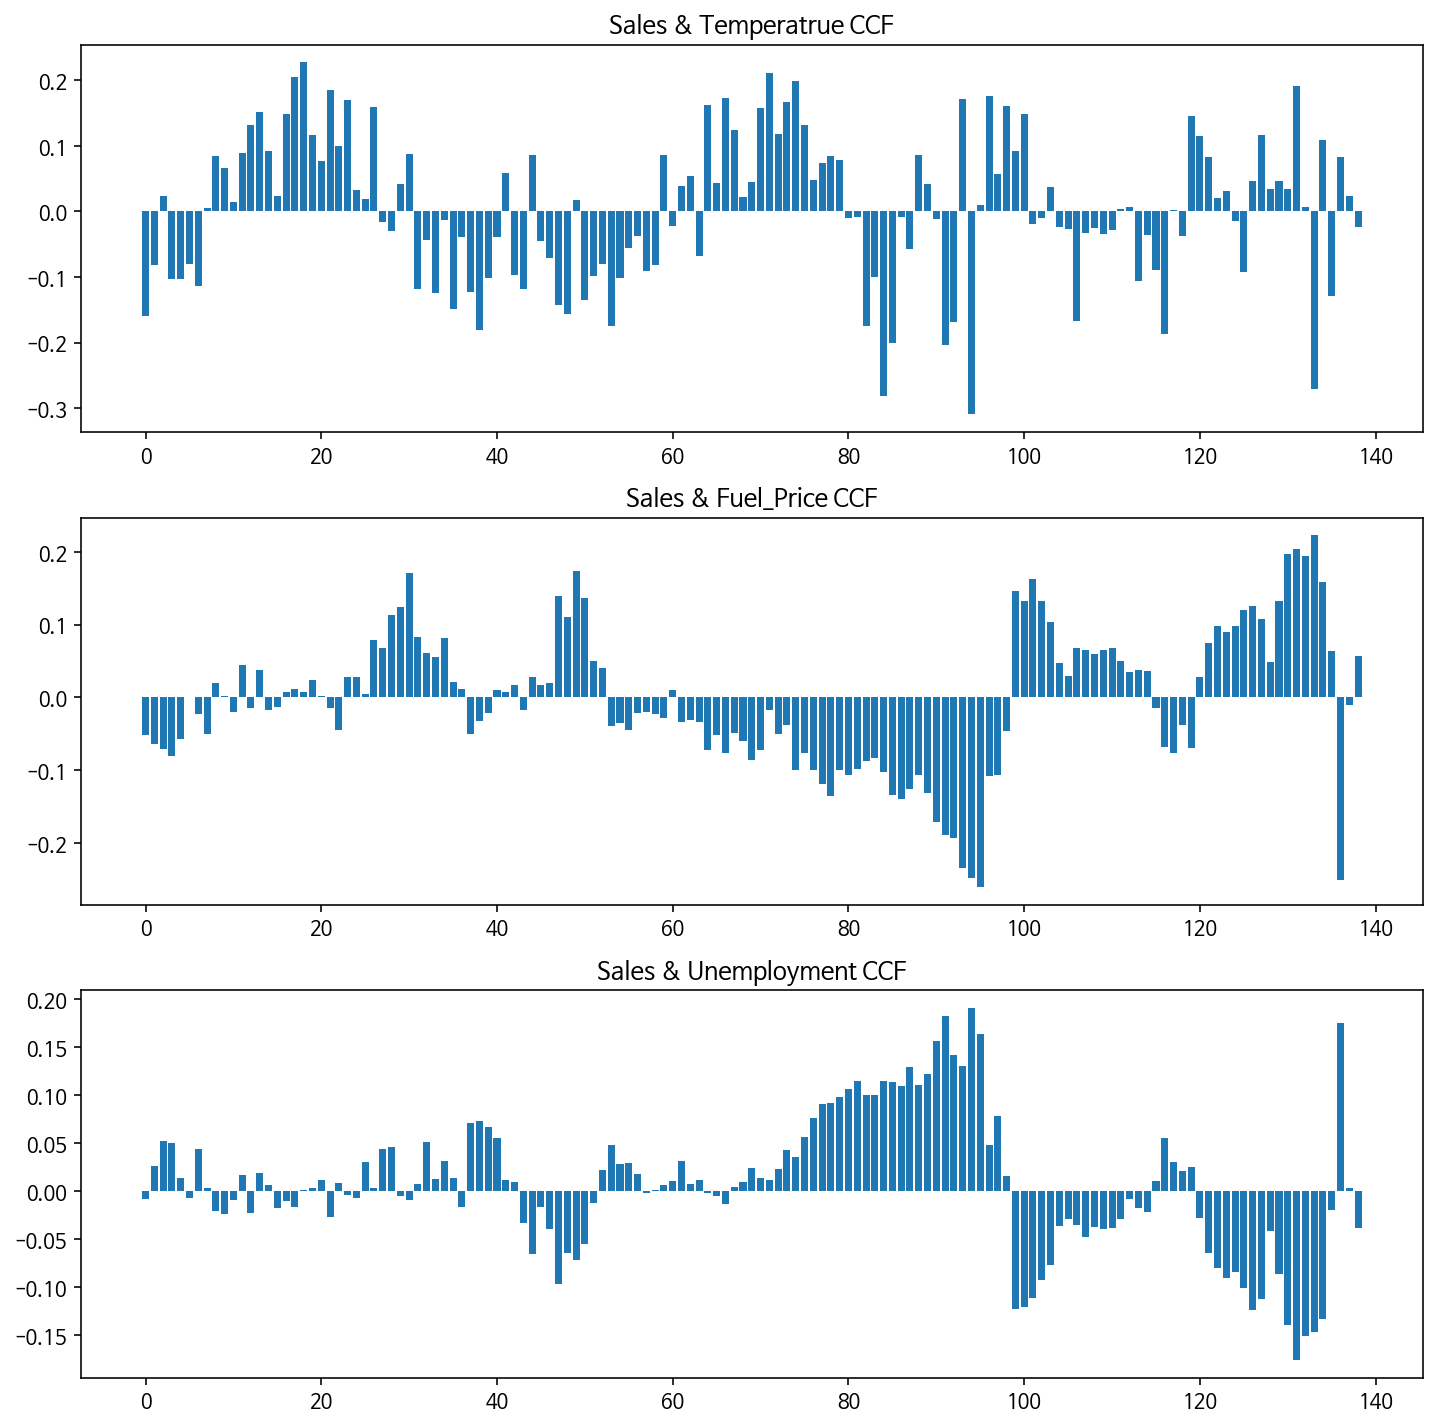

In [ ]:
import statsmodels.api as sm


numeric = data[["Date", "Temperature", "Fuel_Price", "Unemployment", "Weekly_Sales"]]
numeric = numeric.groupby("Date").mean()

#calculate cross correlation
temp_ccf = sm.tsa.stattools.ccf(numeric["Weekly_Sales"], numeric["Temperature"])
fuel_ccf = sm.tsa.stattools.ccf(numeric["Weekly_Sales"], numeric["Fuel_Price"])
unem_ccf = sm.tsa.stattools.ccf(numeric["Weekly_Sales"], numeric["Unemployment"])

fig, axes = plt.subplots(3,1, figsize = (10, 10))

axes[0].bar(list(range(len(temp_ccf))), temp_ccf)
axes[0].set_title("Sales & Temperatrue CCF")
axes[1].bar(list(range(len(temp_ccf))), fuel_ccf)
axes[1].set_title("Sales & Fuel_Price CCF")
axes[2].bar(list(range(len(temp_ccf))), unem_ccf)
axes[2].set_title("Sales & Unemployment CCF")

plt.tight_layout()
plt.show()

숫자형 변수들과 매출액의 교차 상관관계를 시각화한 결과 다음과 같은 내용을 도출할 수 있었습니다.
- 각 시점별로 0이 아닌 값을 가졌기 때문에 각 변수마다 매출액과 상관관계가 존재합니다.

### 6.3 VAR 분석

VAR 분석은 Vector Auto-Regression의 줄임말로 벡터 자기회귀모형이라고도 불립니다.

해당 분석이 일반 시계열 분석과 다른점은 종속변수가 1개가 아닌 2개 이상인 다변량 시계열 분석입니다.

예를 들면 t시점의 매출액이 t-1시점의 매출액과 t-1시점의 기온에 영향을 받는 구조입니다.

현재 데이터셋은 매출액을 영향을 주는 변수로써 Temperature, Fuel_Price, Unemployment로 2가지 이상의 종속 변수가 사용되기에 VAR 분석이 적절합니다.

In [ ]:
from statsmodels.tsa.api import VAR

forecasting_model = VAR(numeric)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


VAR 모델링 과정에서 최적의 모델을 찾기 위한 기준으로 AIC를 선택하였으며 AIC가 가장 낮은 순서(Order) p가 최적의 모델이라고 볼 수 있습니다.

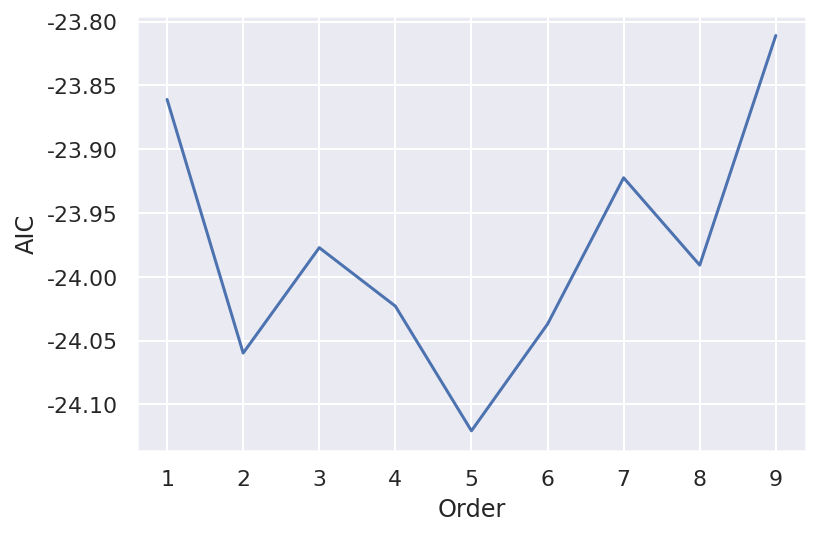

In [ ]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

위의 그림을 통하여 최적의 모델을 찾기 위해서 AIC가 가장 낮은 값을 시각화시킨 결과 Order가 5인 지점이 가장 낮기에 p는 5를 사용합니다.

In [ ]:
results = forecasting_model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Jul, 2022
Time:                     11:03:42
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -22.3042
Nobs:                     134.000    HQIC:                  -23.3826
Log likelihood:           939.539    FPE:                3.38077e-11
AIC:                     -24.1208    Det(Omega_mle):     1.88846e-11
--------------------------------------------------------------------
Results for equation Temperature
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.408883         0.307106            1.331           0.183
L1.Temperature          0.193226         0.106155            1.820           0.069
L1.Fuel_Price           0.076079         0.141

VAR 분석을 진행한 결과 위의 내용과 같이 나왔으며 내용을 정리하면 다음과 같습니다.
- Weekly_Sales 변수와 연관된 변수들 중에서 prob이 0.05보다 작아서 통계적으로 유의한 변수는 다음과 같습니다.
  - L2.Temperature : prob = 0.039 coef = 0.057343
  - L5.Fuel_Price : prob = 0.031 coef = 0.077159

해당 결과를 해석하면 다음과 같은 회귀식이 나옵니다.  
```매출액 = 0.057 * L2.Temperature + 0.077159 * L5.Fuel_Price ```

위의 회귀식을 통하여 Temperature와 Fuel_Price가 오르면 매출액도 상승한다는 결론을 얻게 됩니다.

## 7. 결론

앞서 데이터 EDA 및 시각화로 얻은 인사이트와 VAR 분석을 통하여 얻은 인사이트가 서로 다른 결과를 나타내고 있습니다.

시각화 단계에서는 Temperature가 감소 하거나 Fuel_Price가 상승하기 시작하면 Weekly_Sales는 급격히 상승하는 현상이 있었습니다.

하지만 VAR 분석에서는 Temperature가 상승 하거나 Fuel_Price가 상승하면 Weekly_Sales가 상승한다는 결론을 얻었습니다.

두 가지 분석에서 얻은 결론은 다음과 같습니다.
- Temperature이 상승할 때 매출액이 상승할지 감소할지 모르겠지만 영향력을 끼치고 있다는 점은 확실합니다.
- 시각화와 VAR 분석에서 Fuel_Price가 상승하면 Weekly_Sales도 상승한다는 공통된 의견을 도출할 수 있었습니다.

이외에도 Promotion 변수에서 얻은 결론은 다음과 같습니다.
- Promotion3 변수는 매출의 변동에 큰영향을 끼쳤다 볼 수 있습니다.
- Promotion3에 의해서 영향을 받은 Store는 이후로 추가적인 Promotion을 진행한 것으로 볼 수 있습니다.

## 8. 참고 자료


- https://skyeong.net/285
- https://link.medium.com/CTzjwlKG2rb
- https://signature95.tistory.com/56
- https://stackoverflow.com/questions/63491991/how-to-use-the-ccf-method-in-the-statsmodels-library
- https://dining-developer.tistory.com/32